# Rossmann Store Sales

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You can download the dataset here: https://www.kaggle.com/datasets/shahpranshu27/rossman-store-sales

**Id** - an Id that represents a (Store, Date) duple within the test set  
**Store** - a unique Id for each store  
**Sales** - the turnover for any given day (this is what you are predicting)  
**Customers** - the number of customers on a given day  
**Open** - an indicator for whether the store was open: 0 = closed, 1 = open  
**StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends.  
&nbsp;&nbsp;&nbsp;&nbsp;a = public holiday, b = Easter holiday, c = Christmas, 0 = None  
**SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools  
**StoreType** - differentiates between 4 different store models: a, b, c, d  
**Assortment** - describes an assortment level: a = basic, b = extra, c = extended  
**CompetitionDistance** - distance in meters to the nearest competitor store  
**CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened  
**Promo** - indicates whether a store is running a promo on that day  
**Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating  
**Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2  
**PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew.  
&nbsp;&nbsp;&nbsp;&nbsp;E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store 

### Importing required libraries

In [1]:
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For creating static plots
%matplotlib inline
# To display plots inline in Jupyter notebooks
import seaborn as sns  # For advanced data visualization
import plotly.express as px  # For interactive plotting with Plotly
import plotly.graph_objects as go  # For creating detailed interactive visualizations
# Machine learning preprocessing
from sklearn.preprocessing import RobustScaler  # Used for scaling data while being robust to outliers

# Ignoring warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings

### Helper Functions <a id='imports'></a>

In [2]:
def data_overview(df, name="DataFrame"):
    """
    Show basic structure of the DataFrame:
    - Shape
    - Column names
    - Data types and non-null values
    """
    print(f"\n--- Overview of {name} ---")
    print(f"Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\n--- Info ---")
    print(df.info())


def data_statistics(df, name="DataFrame"):
    """
    Show statistical summary of the DataFrame:
    - Descriptive statistics for all columns
    - Number of unique values per column
    """
    print(f"\n--- Descriptive Statistics of {name} ---")
    print(df.describe(include='all').transpose())
    
    print(f"\n--- Unique Values per Column in {name} ---")
    print(df.nunique().sort_values())


def missing_values_report(df, name="DataFrame"):
    """
    Show missing values in the DataFrame:
    - Count of missing values
    - Percentage of missing values
    """
    print(f"\n--- Missing Values in {name} ---")
    missing_count = df.isnull().sum()
    missing_percent = (missing_count / len(df)) * 100

    missing_data = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing %': missing_percent
    })

    missing_data = missing_data[missing_data['Missing Count'] > 0]
    print(missing_data.sort_values(by='Missing %', ascending=False))


def plot_distribution(df, col):
    plt.figure(figsize=(8,4))
    if df[col].dtype == 'object':
        sns.countplot(data=df, x=col)
    else:
        sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

def correlation_matrix(df, numeric_cols):
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title("Correlation Matrix")
    plt.show()

def analyze_outliers(df, column):
    # Calculate Interquartile Range (IQR)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers using IQR method
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    # Print statistical information
    print(f"Outlier analysis for column: '{column}'")
    print("-" * 40)
    print(f"Total records: {len(df)}")
    print(f"Number of outliers: {len(outliers)}")
    print(f"Percentage of outliers: {round(len(outliers) / len(df) * 100, 2)}%")
    print(f"IQR: {IQR}")
    print(f"Lower bound: {lower_bound}")
    print(f"Upper bound: {upper_bound}")
    print(f"Column mean: {df[column].mean()}")
    print(f"Column median: {df[column].median()}")
    print(f"Column min: {df[column].min()}")
    print(f"Column max: {df[column].max()}")
    print("-" * 40)

    # Visualize the outliers using seaborn boxplot with a clean palette
    plt.figure(figsize=(8, 5))
    sns.set_theme(style="whitegrid", palette="rocket")
    sns.boxplot(y=df[column], color=sns.color_palette("Set2")[0])
    plt.title(f"Box Plot for '{column}' (Outlier Detection)", fontsize=14)
    plt.ylabel(column)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    return outliers



def show_value_counts(df, columns):
    """
    Display value counts for a list of columns in a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame
    columns (list): A list of column names for which to show value counts
    """
    for col in columns:
        print(f"--- Value Counts for column: '{col}' ---")
        print(df[col].value_counts())
        print("-" * 50)

### Loading Data

In [3]:
# Reading the dataset from a CSV file
df_store = pd.read_csv(r"C:\Users\momer\0 Data Science\Rossmann_DEPI_Project\Data\store.csv")  # Load data from 'store.csv' into a DataFrame
df_store.head()  # Display the first 5 rows of the dataset to check its structure

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
# Renaming columns in the DataFrame for easier access and consistency
df_store.rename(columns={'CompetitionDistance': 'compdistance'}, inplace=True)  # Renaming 'CompetitionDistance' to 'compdistance'
df_store.rename(columns={'CompetitionOpenSinceMonth': 'compmonth'}, inplace=True)  # Renaming 'CompetitionOpenSinceMonth' to 'compmonth'
df_store.rename(columns={'CompetitionOpenSinceYear': 'compyear'}, inplace=True)  # Renaming 'CompetitionOpenSinceYear' to 'compyear'

In [5]:
# Checking the shape of the dataset
df_store.shape  # Returns a tuple representing the number of rows and columns in the DataFrame


(1115, 10)

In [6]:
# Getting a concise summary of the DataFrame
df_store.info()  # Displays information about the DataFrame, such as column names, non-null counts, and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Store            1115 non-null   int64  
 1   StoreType        1115 non-null   object 
 2   Assortment       1115 non-null   object 
 3   compdistance     1112 non-null   float64
 4   compmonth        761 non-null    float64
 5   compyear         761 non-null    float64
 6   Promo2           1115 non-null   int64  
 7   Promo2SinceWeek  571 non-null    float64
 8   Promo2SinceYear  571 non-null    float64
 9   PromoInterval    571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [7]:
# Reading the training data from a CSV file
df_train = pd.read_csv(r"C:\Users\momer\0 Data Science\Rossmann_DEPI_Project\Data\train.csv")  # Load data from 'train.csv' into a DataFrame
df_train.head()  # Display the first 5 rows of the training dataset to check its structure

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
# Reading the test data from a CSV file
df_test = pd.read_csv(r"C:\Users\momer\0 Data Science\Rossmann_DEPI_Project\Data\test.csv")  # Load data from 'test.csv' into a DataFrame
df_test.head()  # Display the first 5 rows of the test dataset to check its structure

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [9]:
# Merge store data with train and test datasets
train_merged = pd.merge(df_train, df_store, how='inner', on='Store')
test_merged = pd.merge(df_test, df_store, how='inner', on='Store')

# Add a flag to identify test data
train_merged['is_test'] = False
test_merged['is_test'] = True

# Add a placeholder for 'Sales' in the test set
test_merged['Sales'] = np.nan

# Combine both datasets into one for preprocessing
df = pd.concat([train_merged, test_merged], ignore_index=True)

# Show basic info
print("Combined dataset shape:", df.shape)
df.head()

Combined dataset shape: (1058297, 20)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,compdistance,compmonth,compyear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,is_test,Id
0,1,5,2015-07-31,5263.0,555.0,1.0,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,False,NaN
1,1,4,2015-07-30,5020.0,546.0,1.0,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,False,NaN
2,1,3,2015-07-29,4782.0,523.0,1.0,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,False,NaN
3,1,2,2015-07-28,5011.0,560.0,1.0,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,False,NaN
4,1,1,2015-07-27,6102.0,612.0,1.0,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,False,NaN


In [10]:
# Show basic information about the full dataset structure
data_overview(df, name="Full Data")


--- Overview of Full Data ---
Shape: (1058297, 20)
Columns: ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'compdistance', 'compmonth', 'compyear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'is_test', 'Id']

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1058297 entries, 0 to 1058296
Data columns (total 20 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Store            1058297 non-null  int64  
 1   DayOfWeek        1058297 non-null  int64  
 2   Date             1058297 non-null  object 
 3   Sales            1017209 non-null  float64
 4   Customers        1017209 non-null  float64
 5   Open             1058286 non-null  float64
 6   Promo            1058297 non-null  int64  
 7   StateHoliday     1058297 non-null  object 
 8   SchoolHoliday    1058297 non-null  int64  
 9   StoreType        1058297 n

In [11]:
# Show summary statistics for numerical columns in the full dataset
data_statistics(df, name="Full Data")


--- Descriptive Statistics of Full Data ---
                     count unique              top     freq         mean  \
Store            1058297.0    NaN              NaN      NaN   558.331493   
DayOfWeek        1058297.0    NaN              NaN      NaN     3.997596   
Date               1058297    990       2015-07-31     1115          NaN   
Sales            1017209.0    NaN              NaN      NaN  5773.818972   
Customers        1017209.0    NaN              NaN      NaN   633.145946   
Open             1058286.0    NaN              NaN      NaN     0.831047   
Promo            1058297.0    NaN              NaN      NaN      0.38207   
StateHoliday       1058297      5                0   895995          NaN   
SchoolHoliday    1058297.0    NaN              NaN      NaN     0.188929   
StoreType          1058297      4                a   573755          NaN   
Assortment         1058297      3                a   557749          NaN   
compdistance     1055559.0    NaN          

In [12]:
# Show missing values count and percentage in the full dataset
missing_values_report(df, name="Full Data")


--- Missing Values in Full Data ---
                 Missing Count  Missing %
Id                     1017209  96.117536
Promo2SinceWeek         525263  49.632854
Promo2SinceYear         525263  49.632854
PromoInterval           525263  49.632854
compmonth               338564  31.991397
compyear                338564  31.991397
Sales                    41088   3.882464
Customers                41088   3.882464
compdistance              2738   0.258718
Open                        11   0.001039


In [13]:
df[df.duplicated()]
# This line returns all duplicated rows in the DataFrame 'df'
# duplicated value is important so we can't remove it

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,compdistance,compmonth,compyear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,is_test,Id


In [14]:
# Drop the 'Id' column from the full_data DataFrame
df.drop(columns=['Id'], inplace=True)

In [15]:
df.loc[df['Promo2'] == 0, ['Promo2SinceWeek', 'Promo2SinceYear']] = 0
df.loc[df['Promo2'] == 0, 'PromoInterval'] = 'noPromo'

In [16]:
# Fill missing values in compmonth and compyear with the median of each column in full_data
df['compmonth'] = df['compmonth'].fillna(df['compmonth'].median())
df['compyear'] = df['compyear'].fillna(df['compyear'].median())

In [17]:
df['compdistance'].skew()
# 2.9451610180461305 means that the data is largely positively skewed.
# So, median imputation will work.

2.9451610180461305

In [18]:
# Filling missing values in the 'compdistance' column with the median value
df['compdistance'].fillna(df['compdistance'].median(), inplace=True)  # Replace NaN values with the median of the column

In [19]:
# Fill missing values in 'Open' column with 1 because missing values are negligible and likely indicate store is open
df['Open'] = df['Open'].fillna(1)

In [20]:
# Show missing values count and percentage in the full dataset
missing_values_report(df, name="Full Data")


--- Missing Values in Full Data ---
           Missing Count  Missing %
Sales              41088   3.882464
Customers          41088   3.882464


--- Outlier Analysis for 'Sales' ---
Outlier analysis for column: 'Sales'
----------------------------------------
Total records: 1058297
Number of outliers: 26694
Percentage of outliers: 2.52%
IQR: 4129.0
Lower bound: -2466.5
Upper bound: 14049.5
Column mean: 5773.818972305593
Column median: 5744.0
Column min: 0.0
Column max: 41551.0
----------------------------------------


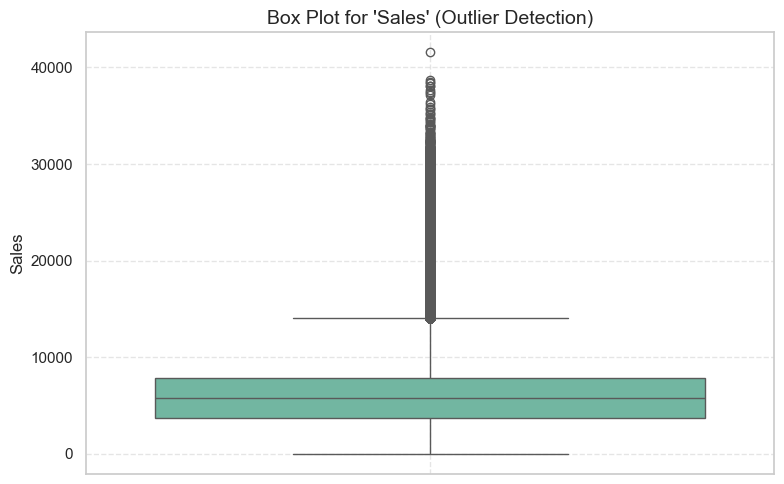


------------------------------------------------------------

--- Outlier Analysis for 'Customers' ---
Outlier analysis for column: 'Customers'
----------------------------------------
Total records: 1058297
Number of outliers: 38095
Percentage of outliers: 3.6%
IQR: 432.0
Lower bound: -243.0
Upper bound: 1485.0
Column mean: 633.1459464082602
Column median: 609.0
Column min: 0.0
Column max: 7388.0
----------------------------------------


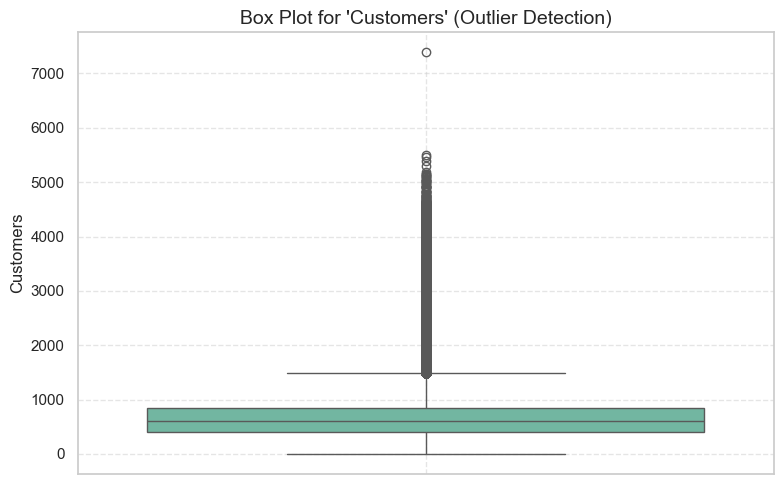


------------------------------------------------------------

--- Outlier Analysis for 'compdistance' ---
Outlier analysis for column: 'compdistance'
----------------------------------------
Total records: 1058297
Number of outliers: 102472
Percentage of outliers: 9.68%
IQR: 6160.0
Lower bound: -8530.0
Upper bound: 16110.0
Column mean: 5408.837453002324
Column median: 2330.0
Column min: 20.0
Column max: 75860.0
----------------------------------------


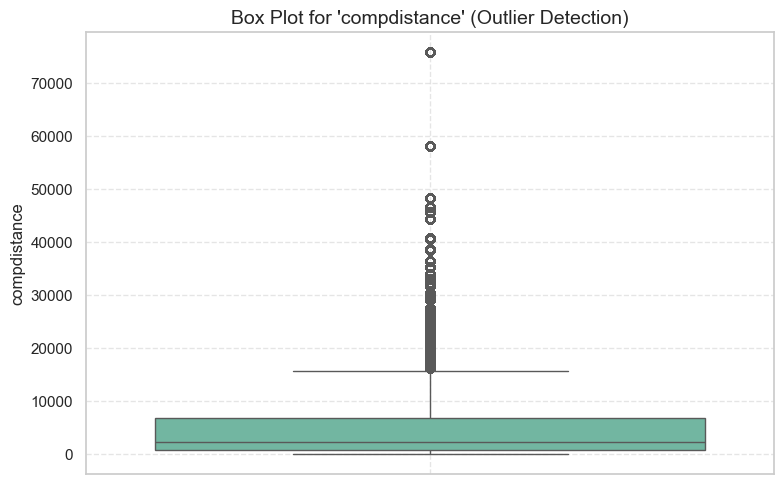


------------------------------------------------------------



In [21]:
# List of numeric columns to analyze for potential outliers
columns_to_check = ['Sales', 'Customers', 'compdistance']

# Loop through each column and apply the outlier analysis function
for column in columns_to_check:
    print(f"--- Outlier Analysis for '{column}' ---")
    analyze_outliers(df, column)  # Using the previously defined function
    print("\n" + "-"*60 + "\n")

In [22]:
# Converting the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')  # Convert 'Date' to datetime, invalid dates will become NaN

In [23]:
df# Extracting year, month, day, and day name from the 'Date' column
df['Year'] = df['Date'].dt.year  # Extract the year from 'Date'
df['Month'] = df['Date'].dt.month  # Extract the month from 'Date'
df['Day'] = df['Date'].dt.day  # Extract the day of the month from 'Date'
df['Day_name'] = df['Date'].dt.day_name()  # Extract the name of the day from 'Date'full_datafull_data

In [24]:
# Define a list of categorical columns to analyze using value counts
cat_columns = ['StateHoliday', 'StoreType', 'Assortment']
show_value_counts(df, cat_columns)

--- Value Counts for column: 'StateHoliday' ---
StateHoliday
0    895995
0    131072
a     20440
b      6690
c      4100
Name: count, dtype: int64
--------------------------------------------------
--- Value Counts for column: 'StoreType' ---
StoreType
a    573755
d    327024
c    141112
b     16406
Name: count, dtype: int64
--------------------------------------------------
--- Value Counts for column: 'Assortment' ---
Assortment
a    557749
c    491822
b      8726
Name: count, dtype: int64
--------------------------------------------------


In [25]:
# Converting the 'StateHoliday' column to string type
df['StateHoliday'] = df['StateHoliday'].astype(str)  # Converts the 'StateHoliday' column to string

In [26]:
# Splitting the merged DataFrame `df` back into training and testing sets

# The training set: rows where both 'sales' and 'customers' are not missing
train_df = df[df['Sales'].notna() & df['Customers'].notna()].copy()

# The test set: rows where either 'sales' or 'customers' are missing
test_df = df[df['Sales'].isna() & df['Customers'].isna()].copy()

# Resetting indices for both datasets (optional but recommended for clean indexing)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [27]:
# Assigning the training data as the clean dataset
clean_data = train_df.copy()

# Saving the clean dataset to a CSV file
clean_data.to_csv('clean_data.csv', index=False)

# Optional: print confirmation
print("Clean data has been saved to 'clean_data.csv'.")

Clean data has been saved to 'clean_data.csv'.


In [28]:
# Save the raw test dataset
test_df.to_csv("test_data.csv", index=False)